In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

from textwrap import wrap

from copy import deepcopy

In [2]:
test = jnp.exp(-1/500).item()

test

0.9980019927024841

In [3]:
training_data = 'abcdefghijklmnopqrstuvwxyz'*2000

chars = set(list(training_data))

vocab_size = len(chars)

char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(f'{vocab_size} unique characters')
print(f'{len(training_data)} total characters')

26 unique characters
52000 total characters


In [4]:
hidden_size = 30

seq_length = 10

total_params = 5 * hidden_size * vocab_size + 4 * hidden_size**2 + 4 * hidden_size + vocab_size 

print(f'LSTM with {hidden_size} hidden units')
print(f'Single layer LSTM has {total_params} total parameters')
print(f'Will train on character sequences of length {seq_length}')
print()
txt = wrap(training_data[len(training_data)//2:(len(training_data)//2)+200])
txt = [line.center(100) for line in txt]
txt = '\n'.join(txt)
print('Training data sample: \n')
print(txt)
print()

LSTM with 30 hidden units
Single layer LSTM has 7646 total parameters
Will train on character sequences of length 10

Training data sample: 

               abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqr               
               stuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghij               
                    klmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqr                    



In [5]:
def initialize_weights(key,n_h,n_x):
    
    subkeys=random.split(key,9)

    params = dict()

    params['Wxc'] = random.normal(subkeys[0],(n_h,n_x))*0.01 # input to cell state
    params['Wxu'] = random.normal(subkeys[1],(n_h,n_x))*0.01 # input to update
    params['Wxf'] = random.normal(subkeys[2],(n_h,n_x))*0.01 # input to forget
    params['Wxo'] = random.normal(subkeys[3],(n_h,n_x))*0.01 # input to output

    params['bc'] = jnp.zeros((n_h, 1)) # hidden bias
    params['bu'] = jnp.zeros((n_h, 1)) # forget bias
    params['bf'] = jnp.zeros((n_h, 1)) # update bias
    params['bo'] = jnp.zeros((n_h, 1)) # output bias

    params['Whc'] = random.normal(subkeys[4],(n_h,n_h))*0.01 # hidden to cell
    params['Whu'] = random.normal(subkeys[5],(n_h,n_h))*0.01 # hidden to update
    params['Whf'] = random.normal(subkeys[6],(n_h,n_h))*0.01 # hidden to forget
    params['Who'] = random.normal(subkeys[7],(n_h,n_h))*0.01 # hidden to output

    params['Why'] = random.normal(subkeys[8],(n_x,n_h))*0.01 # hidden to output
    params['by'] = jnp.zeros((n_x, 1)) # output bias

    grad_mems = dict()
    sqrd_mems = dict()

    for parameter in params.keys():

        shape = params[parameter].shape

        grad_mems[parameter]=jnp.zeros(shape)
        sqrd_mems[parameter]=jnp.zeros(shape)

    return params, grad_mems, sqrd_mems

In [6]:
start_key = random.PRNGKey(0)

params,grad_mems,sqrd_mems = initialize_weights(start_key,hidden_size,vocab_size)

print(params.keys())
print(jnp.mean(params['Wxc']))
print(jnp.mean(grad_mems['Wxc']))
print(jnp.mean(sqrd_mems['Wxc']))

dict_keys(['Wxc', 'Wxu', 'Wxf', 'Wxo', 'bc', 'bu', 'bf', 'bo', 'Whc', 'Whu', 'Whf', 'Who', 'Why', 'by'])
-9.268721e-05
0.0
0.0


In [7]:
def get_mini_batch(mini_batch_size,seq_length,char_to_ix,data):
    '''
    generator to continuous loop the data and pull out mini batches
    '''
    p = 0
    epoch = 0

    batch_character_size = mini_batch_size*(seq_length)

    while True:

        if p+batch_character_size+1>=len(data):
            p=0
            epoch = epoch + 1

            # need to reset hprev,cprev if it loops?

        inputs,targets = [],[]

        for _ in range(mini_batch_size):

            inputs.append([char_to_ix[ch] for ch in data[p:p+seq_length]])
            targets.append([char_to_ix[ch] for ch in data[p+1:p+seq_length+1]])

            p += seq_length

        inputs = jnp.array(inputs)
        targets = jnp.array(targets)

        yield inputs,targets,epoch

In [8]:
batch_gen = get_mini_batch(4,seq_length,char_to_ix,training_data)

inp,targ,epoch_test = next(batch_gen)

display(inp,targ,epoch_test)

Array([[21, 20, 18, 12, 17, 25, 22,  0, 13, 10],
       [16,  3, 24,  9,  5,  1,  7, 11, 19,  6],
       [ 4, 15, 14,  8,  2, 23, 21, 20, 18, 12],
       [17, 25, 22,  0, 13, 10, 16,  3, 24,  9]], dtype=int32)

Array([[20, 18, 12, 17, 25, 22,  0, 13, 10, 16],
       [ 3, 24,  9,  5,  1,  7, 11, 19,  6,  4],
       [15, 14,  8,  2, 23, 21, 20, 18, 12, 17],
       [25, 22,  0, 13, 10, 16,  3, 24,  9,  5]], dtype=int32)

0

In [9]:
def sigmoid(z):
    return 1.0/(1.0 + jnp.exp(-z))

def softmax(y):
    return jnp.exp(y) / jnp.sum(jnp.exp(y),axis=0)

def lstm_forward(inputs,hprev,cprev,params):
    '''
    single forward pass of the LSTM

    returns loss for this mini-batch

    returns cache of variables needed for backwards pass
    '''

    # dims
    mini_batch_size = inputs.shape[0]
    seq_length = inputs.shape[1]

    hidden_size = hprev.shape[0]

    vocab_size = params['Wxc'].shape[1]

    # unpack params

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    #Why = params['Why']
    #by = params['by']

    # caches for forward pass

    xs, hs, cs, c_tildes = {}, {}, {}, {}

    gamma_us, gamma_fs, gamma_os = {}, {}, {}

    hs[-1] = jnp.tile(hprev,(1,mini_batch_size))
    cs[-1] = jnp.tile(cprev,(1,mini_batch_size))

    for t in range(seq_length):
        xs[t] = jnp.zeros((vocab_size,mini_batch_size))

        xs[t] = xs[t].at[inputs[:,t],jnp.arange(mini_batch_size)].set(1) # batch of one-hot vectors for time t

        zc = jnp.dot(Wxc,xs[t]) + jnp.dot(Whc,hs[t-1]) + bc  # linear activation for candidate cell state C~
        zu = jnp.dot(Wxu,xs[t]) + jnp.dot(Whu,hs[t-1]) + bu  # linear activation for update gate
        zf = jnp.dot(Wxf,xs[t]) + jnp.dot(Whf,hs[t-1]) + bf  # linear activation for forget gate
        zo = jnp.dot(Wxo,xs[t]) + jnp.dot(Who,hs[t-1]) + bo  # linear activation for output gate

        c_tildes[t] = jnp.tanh(zc) # canidate for new c state

        gamma_us[t] = sigmoid(zu)
        gamma_fs[t] = sigmoid(zf)
        gamma_os[t] = sigmoid(zo)

        cs[t] = jnp.tanh(jnp.multiply(c_tildes[t],gamma_us[t]) + jnp.multiply(cs[t-1],gamma_fs[t]))  # tanh here is import!!!

        hs[t] = jnp.multiply(cs[t],gamma_os[t]) # hidden state

    gates = (gamma_us,gamma_fs,gamma_os)

    states = (xs,hs,cs,c_tildes)

    return states, gates

def loss_function(targets,hidden_states,Why,by):
    '''
    hidden_states - dict of LSTM activations from last LSTM layer
    '''

    mini_batch_size=targets.shape[0]
    seq_length = targets.shape[1]

    ys, ps = {},{}

    loss = 0

    for t in range(seq_length):

        ys[t] = jnp.dot(Why, hidden_states[t]) + by # unnormalized log probabilities for next chars

        ps[t] = softmax(ys[t]) # probabilities for next chars  #  ps[t] should be shape (vocab_size,mini_batch_size)

        loss += jnp.mean(jnp.log(jnp.sum(jnp.exp(ys[t]),axis=0)) - ys[t][targets[:,t],jnp.arange(mini_batch_size)])
        #loss += -jnp.mean(jnp.log(ps[t][targets[:,t],jnp.arange(mini_batch_size)]))

    p_cache = (ys,ps)

    return loss, p_cache



In [10]:
h = jnp.zeros((hidden_size,1))
c = jnp.zeros((hidden_size,1))

s_cache, g_cache = lstm_forward(inp,h,c,params)

h_states = s_cache[1]

test_loss,p_cache = loss_function(targ,h_states,params['Why'],params['by'])

In [11]:
test_loss

Array(32.58093, dtype=float32)

In [12]:
print(type(p_cache),len(p_cache))
print(type(g_cache),len(g_cache))
print(type(s_cache),len(s_cache))

<class 'tuple'> 2
<class 'tuple'> 3
<class 'tuple'> 4


In [13]:
%timeit lstm_forward(inp,h,c,params)

162 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
lstm_forward_jit = jit(lstm_forward)

#warmup
lstm_forward_jit(inp,h,c,params)

%timeit lstm_forward_jit(inp,h,c,params)

871 µs ± 267 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:

def lstm_backward(targets,probs_cache,gates_cache,states_cache,params):
    '''
    backward pass of the LSTM

    return gradients for all parameters
    '''
    #unpack caches

    ys,ps = probs_cache

    gamma_us,gamma_fs,gamma_os = gates_cache

    xs,hs,cs,c_tildes = states_cache

    # dims
    mini_batch_size = targets.shape[0]
    seq_length = targets.shape[1]

    hidden_size = hs[-1].shape[0]

    vocab_size = params['Wxc'].shape[1]

    # unpack parameters

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    Why = params['Why']
    by = params['by']

    #initialize gradients to zero

    dWxc,dWxu,dWxf,dWxo = jnp.zeros_like(Wxc), jnp.zeros_like(Wxu), jnp.zeros_like(Wxf), jnp.zeros_like(Wxo)
    dWhc,dWhu,dWhf,dWho = jnp.zeros_like(Whc), jnp.zeros_like(Whu), jnp.zeros_like(Whf), jnp.zeros_like(Who)
    dbc,dbu,dbf,dbo = jnp.zeros_like(bc), jnp.zeros_like(bu), jnp.zeros_like(bf), jnp.zeros_like(bo)
    dWhy,dby = jnp.zeros_like(Why), jnp.zeros_like(by)

    # tmp variables to accumulate gradients over the backprop -- see differentiation graph
    dhnext, dcnext = jnp.zeros_like(hs[0]), jnp.zeros_like(cs[0])

    #backward pass

    for t in reversed(range(seq_length)):
        dy = jnp.copy(ps[t])

        dy = dy.at[targets[:,t],jnp.arange(mini_batch_size)].add(-1) #backprop into y

        dWhy += jnp.dot(dy, hs[t].T)
        dby += jnp.sum(dy,axis=1,keepdims=True)

        dh = jnp.dot(Why.T, dy) + dhnext # backprop into h

        dc = jnp.multiply((1-cs[t]**2),jnp.multiply(gamma_os[t],dh) + dcnext) #backprop into c

        dcnext = jnp.multiply(gamma_fs[t],dc)

        dzc = jnp.multiply((1-c_tildes[t]**2),jnp.multiply(gamma_us[t],dc))  # backprop through tanh

        dzu = jnp.multiply(gamma_us[t]*(1-gamma_us[t]),jnp.multiply(c_tildes[t],dc))  # sigmoid prime

        dzf = jnp.multiply(gamma_fs[t]*(1-gamma_fs[t]),jnp.multiply(cs[t-1],dc))

        dzo = jnp.multiply(gamma_os[t]*(1-gamma_os[t]),jnp.multiply(cs[t],dh))

        dbc += jnp.sum(dzc,axis=1,keepdims=True)
        dbu += jnp.sum(dzu,axis=1,keepdims=True)
        dbf += jnp.sum(dzf,axis=1,keepdims=True)
        dbo += jnp.sum(dzo,axis=1,keepdims=True)

        dWhc += jnp.dot(dzc,hs[t-1].T)
        dWhu += jnp.dot(dzu,hs[t-1].T)
        dWhf += jnp.dot(dzf,hs[t-1].T)
        dWho += jnp.dot(dzo,hs[t-1].T)

        dWxc += jnp.dot(dzc,xs[t].T)
        dWxu += jnp.dot(dzu,xs[t].T)
        dWxf += jnp.dot(dzf,xs[t].T)
        dWxo += jnp.dot(dzo,xs[t].T)

        # four contributions to dhnext,one from each gate
        dhnext = jnp.dot(Whc.T,dzc) + jnp.dot(Whu.T,dzu) + jnp.dot(Whf.T,dzf) + jnp.dot(Who.T,dzo)

    grads = dict()

    grads['Wxc']=dWxc
    grads['Wxu']=dWxu
    grads['Wxf']=dWxf
    grads['Wxo']=dWxo

    grads['Whc']=dWhc
    grads['Whu']=dWhu
    grads['Whf']=dWhf
    grads['Who']=dWho

    grads['bc']=dbc
    grads['bu']=dbu
    grads['bf']=dbf
    grads['bo']=dbo

    grads['Why']=dWhy
    grads['by']=dby

    for parameter in grads.keys():
        grads[parameter] = jnp.clip(grads[parameter], -5, 5) # clip to mitigate exploding gradients

    return grads

In [16]:
grads_test = lstm_backward(targ,p_cache,g_cache,s_cache,params)

print(type(grads_test),len(grads_test))

<class 'dict'> 14


In [32]:

def sgd_step_adam(current_step,inputs,targets,h,c,params,grads_mems,sqrd_mems,beta1,beta2,learning_rate):

    # dims
    mini_batch_size = inputs.shape[0]
    seq_length = inputs.shape[1]

    hidden_size = h.shape[0]

    vocab_size = params['Wxc'].shape[1]

    n = current_step

    #forward pass
    s_cache, g_cache = lstm_forward(inputs,h,c,params)

    loss, p_cache = loss_function(targets,s_cache[1],params['Why'],params['by'])
    
    #need hs, cs

    xs,hs,cs,c_tildes = s_cache

    #h_next = jnp.mean(hs[seq_length-1],axis=1,keepdims=True)
    #c_next = jnp.mean(cs[seq_length-1],axis=1,keepdims=True)

    h_next = jnp.expand_dims(hs[seq_length-1][:,-1],1)
    c_next = jnp.expand_dims(cs[seq_length-1][:,-1],1)

    new_params = deepcopy(params)

    new_mems1 = deepcopy(grads_mems)
    new_mems2 = deepcopy(sqrd_mems)

    #backward pass
    grads = lstm_backward(targets,p_cache,g_cache,s_cache,params)

    # perform parameter update with ADAM 
    for parameter in new_params.keys():

        dparam = grads[parameter] / mini_batch_size

        new_mems1[parameter] = beta1*new_mems1[parameter] + (1-beta1)*dparam

        new_mems2[parameter] = beta2*new_mems2[parameter] + (1-beta2)*dparam*dparam

        grad_hat = new_mems1[parameter] / (1-beta1**(n+1))
        sqrd_hat = new_mems2[parameter] / (1-beta2**(n+1))

        new_params[parameter] += -learning_rate * grad_hat / (jnp.sqrt(sqrd_hat + 1e-8)) # ADAM update

    params_cache = (new_params,new_mems1,new_mems2)

    hidden_cache = (h_next,c_next)
    
    return loss, params_cache, hidden_cache

In [29]:
def sample(seed_ix, n, key, hidden_cache, params):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """

    h = hidden_cache[0]
    c = hidden_cache[1]

    Wxc = params['Wxc']
    Wxu = params['Wxu']
    Wxf = params['Wxf']
    Wxo = params['Wxo']

    Whc = params['Whc']
    Whu = params['Whu']
    Whf = params['Whf']
    Who = params['Who']

    bc = params['bc']
    bu = params['bu']
    bf = params['bf']
    bo = params['bo']

    Why = params['Why']
    by = params['by']

    vocab_size = Wxc.shape[1]

    x = jnp.zeros((vocab_size, 1))
    x = x.at[seed_ix].set(1)
    ixes = []
    for t in range(n):

        zc = jnp.dot(Wxc,x) + jnp.dot(Whc,h) + bc  # linear activation for candidate cell state C~
        zu = jnp.dot(Wxu,x) + jnp.dot(Whu,h) + bu  # linear activation for update gate
        zf = jnp.dot(Wxf,x) + jnp.dot(Whf,h) + bf  # linear activation for forget gate
        zo = jnp.dot(Wxo,x) + jnp.dot(Who,h) + bo  # linear activation for output gate

        c_tilde = jnp.tanh(zc)

        gamma_u = sigmoid(zu)
        gamma_f = sigmoid(zf)
        gamma_o = sigmoid(zo)

        c = jnp.tanh(jnp.multiply(c_tilde,gamma_u) + jnp.multiply(c,gamma_f))

        h = jnp.multiply(c,gamma_o) # hidden state

        y = jnp.dot(Why, h) + by

        p = softmax(y)

        key,subkey = random.split(key)  #use key to split, subkey for next random number

        ix = random.choice(subkey,vocab_size,p=p.reshape(-1,))

        x = jnp.zeros((vocab_size, 1))
        x = x.at[ix].set(1)

        ixes.append(int(ix))

    return ixes

def validation_loss(inputs,targets,h,c,params):

    s_cache, _ = lstm_forward(inputs,h,c,params)

    h_states = s_cache[1]

    val_loss, _ = loss_function(targets,h_states,params['Why'],params['by'])

    return val_loss

In [34]:
sgd_step_adam_jit = jit(sgd_step_adam)

validation_loss_jit = jit(validation_loss)

def train_character_lstm(seq_length,hidden_size,mini_batch_size,learning_rate,total_steps,steps_sample_freq,initial_key,training_data,validation_data=None):
    '''
    fingers crossed!
    '''

    #unique characters in the data set
    chars = set(list(training_data))
    vocab_size = len(chars)

    #character encoding
    char_to_ix = {ch:i for i,ch in enumerate(chars)}
    ix_to_char = {i:ch for i,ch in enumerate(chars)}

    # initialize data generators
    training_generator = get_mini_batch(mini_batch_size,seq_length,char_to_ix,training_data)
    if validation_data:
       validation_generator = get_mini_batch(mini_batch_size,seq_length,char_to_ix,validation_data)

    #current training step counter
    n = 0

    #initialize the model weight matrices
    params_cache = initialize_weights(initial_key,hidden_size,vocab_size)

    #keep list of loss each training step
    
    step_list = [0]

    tau = len(training_data) / (mini_batch_size * seq_length)

    alpha = jnp.exp(-4/tau).item()

    print(f'tau: {tau} alpha: {alpha}')

    smooth_loss = -jnp.log(1.0/vocab_size)*seq_length

    train_losses,smooth_losses,val_losses = [smooth_loss],[smooth_loss],[smooth_loss]

    last_epoch = 0

    h_next,c_next = jnp.zeros((hidden_size,1)), jnp.zeros((hidden_size,1))

    key = initial_key

    sample_size = 200

    sample_ix = [0]*sample_size

    while n < total_steps:
          
          inputs,targets,current_epoch = next(training_generator)

          if current_epoch > last_epoch:

             last_epoch = current_epoch
             
             h_next,c_next = jnp.zeros((hidden_size,1)),jnp.zeros((hidden_size,1))
          
          current_loss, params_cache, hidden_cache = sgd_step_adam_jit(current_step=n,
                                                     inputs=inputs,
                                                     targets=targets,
                                                     h=h_next,
                                                     c=c_next,
                                                     params=params_cache[0],
                                                     grads_mems=params_cache[1],
                                                     sqrd_mems=params_cache[2],
                                                     beta1=0.9,
                                                     beta2=0.999,
                                                     learning_rate=learning_rate)
          
          
          
          smooth_loss = alpha*smooth_loss + (1-alpha)*current_loss

          #unpack hidden_cache so hidden states passed to next sgd step

          #makes big difference to performance, instead of zeroing h and c every batch... 
          h_next,c_next = hidden_cache

          # sample from the model now and then
          if n % steps_sample_freq == 0:
             key,subkey=random.split(key) #key to split, subkey to gen next random sample

             sample_ix = sample(sample_ix[-1],sample_size,subkey,hidden_cache,params_cache[0])

             txt = ''.join(ix_to_char[ix] for ix in sample_ix)
             txt_wrap = wrap(txt,80)
             txt_wrap = [line.center(100) for line in txt_wrap]
             txt = '\n'.join(txt_wrap)  # \n aren't in the character set so wrap text to make readable

             print('----\n %s \n----' % (txt,))

             print(f'Step n: {n}\t Epoch: {current_epoch}')

             print(f'Train Current: {current_loss:.4f}\tTrain Smoothed: {smooth_loss:.4f}')

             step_list.append(n)
             train_losses.append(current_loss)
             smooth_losses.append(smooth_loss)

             #compute_validation_loss
             if validation_generator:
                inputs_val,targets_val,val_epoch = next(validation_generator)

                val_loss = validation_loss_jit(inputs_val,targets_val,h=h_next,c=c_next,params=params_cache[0])

                print(f'Val Current: {val_loss:.4f}') 

                val_losses.append(val_loss)       

          n+=1

    history = (step_list,smooth_losses,train_losses,val_losses)

    return history, params_cache, hidden_cache

In [20]:
12.75/32.58

0.39134438305709024

In [35]:
mykey = random.PRNGKey(1)

seq_length = 10
hidden_size = 32
mini_batch_size = 16

train_data = training_data
val_data = training_data[513:]

history,out_params,out_hidden = train_character_lstm(                  
                                  seq_length=seq_length,
                                  hidden_size=hidden_size,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=4000,
                                  steps_sample_freq=250,
                                  initial_key=mykey,
                                  training_data=train_data,
                                  validation_data=val_data)                

tau: 325.0 alpha: 0.98776775598526
----
           ewxgrflbdbupejpjyamkqjapymwbjjbiqxcdhwhusgywjitofbmnncmmjwuecgyecwslywhlyawjpjik          
          anxsosvtaahcczeaoapnwdzjpjumjlbswggurpbucwyvfezqlsohjnrtzaspbubwumwieijxvpjoodnv          
                              gdenfppuohwfwzqokvcqfhozutsioanwfinpsurk                               
----
Step n: 0	 Epoch: 0
Train Current: 32.5813	Train Smoothed: 32.5810
Val Current: 32.5692
----
           lmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklm          
          nopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijklmno          
                              pqrstuvwxyzabcdefghijklmnopqrstuvwxyzabc                               
----
Step n: 250	 Epoch: 0
Train Current: 0.0442	Train Smoothed: 2.4042
Val Current: 0.0839
----
           defghijklmnopqrstuvwxxyzabcdhijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefg          
          hijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwx

In [36]:
import matplotlib.pyplot as plt

import numpy as np

def plot_training_history(history,mini_batch_size,seq_length,training_length,plot_smooth=False,plot_val=True):

    step_list,smooth_losses,train_losses,val_losses = history

    fig,ax = plt.subplots(figsize=(10,6))

    t_list = np.array(step_list)

    t_list = t_list * mini_batch_size * seq_length / training_length

    train_log_loss = np.log10(np.array(train_losses))

    if plot_smooth:
       smooth_log_loss = np.log10(np.array(smooth_losses))
       ax.plot(t_list,smooth_log_loss,'bo-')

    ax.plot(t_list,train_log_loss,'go-')

    if len(val_losses)==len(step_list) and plot_val:
       val_log_loss = np.log10(np.array(val_losses))

       ax.plot(t_list,val_log_loss,'ro-')

    ax.set_ylabel('$Log_{10}(L)$')
    ax.set_xlabel('Epochs')

    plt.show()

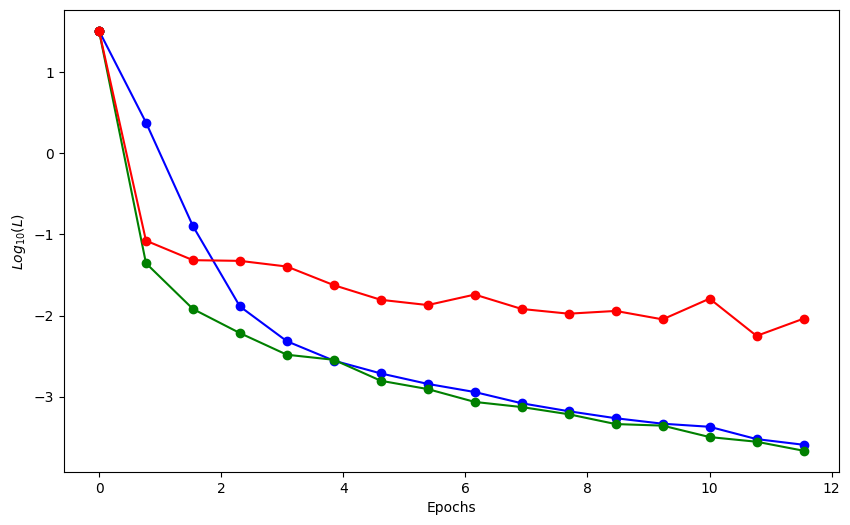

In [37]:
plot_training_history(history,
                      mini_batch_size,
                      seq_length,
                      len(training_data),
                      plot_smooth=True,
                      plot_val=True)

In [38]:
import re

with open('illiad_clean.txt','r') as file:
  text_data = file.read()

text_data = re.sub(r"\[.\]"," ",text_data)

text_data = re.sub(r"[^a-zA-Z0-9.,?!:;“”'`’ ]+", " ", text_data)

text_data = re.sub(r"[\s]+"," ",text_data)

train_split = 0.85
n_train = int(len(text_data)*train_split)

training_data = text_data[:n_train]
validation_data = text_data[n_train:]

chars = set(list(training_data))

vocab_size = len(chars)

char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(f'{vocab_size} unique characters')
print(f'Training has {len(training_data)} total characters')
print(f'Validation has {len(validation_data)} total characters')

seq_length = 100
hidden_size = 128

total_params = 5 * hidden_size * vocab_size + 4 * hidden_size**2 + 4 * hidden_size + vocab_size

print(f'LSTM with {hidden_size} hidden units')
print(f'Single layer LSTM has {total_params} total parameters')
print(f'Will train on character sequences of length {seq_length}')
print()
txt = wrap(training_data[len(training_data)//2:(len(training_data)//2)+200])
txt = [line.center(100) for line in txt]
txt = '\n'.join(txt)
print('Training data sample: \n')
print(txt)
print()

73 unique characters
Training has 740442 total characters
Validation has 130667 total characters
LSTM with 128 hidden units
Single layer LSTM has 112841 total parameters
Will train on character sequences of length 100

Training data sample: 

               ide, At once a virgin, and at once a bride! No more with presents her                
               embraces meet, Or lay the spoils of conquest at her feet, On whom his                
                    passion, lavish of his store, Bestow’d so much, and vainly p                    



In [39]:
mykey = random.PRNGKey(1)

mini_batch_size = 32

total_steps = 2000

history,out_params,out_hidden = train_character_lstm(                  
                                  seq_length=seq_length,
                                  hidden_size=hidden_size,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=total_steps,
                                  steps_sample_freq=100,
                                  initial_key=mykey,
                                  training_data=training_data,
                                  validation_data=validation_data)     

tau: 231.388125 alpha: 0.9828615784645081
----
           ”kqmd'Ja0!1pU7p7ugNFQrgMyH4arrP5ZnIiM4X1bmuV7vo6'aW88”NW7k1U;mlU;4K3lVM3lgk7Er5.          
                  9YxbBKeoL9h;IfcgR9yYk0SjEr,H73PKVzL dEa,I4T“CUSZu?6hr8GoO9bEP aV                  
                      WVvcvjn“pj6R0YemwsYCyp,6hVCkOQ6eDI’'MRm1obvBgAkCvApb dF                        
----
Step n: 0	 Epoch: 0
Train Current: 429.0423	Train Smoothed: 429.0459
Val Current: 427.1728
----
             urdaed The cirmondinctulce bee ere. Whe caast, Hucea sh tog dy thedsn shas,             
            shaand an sryetht  innthe: 3e Code fand thine stuace Ir the, wit wime hinge             
                          fumnen miret wpeene all Rich shitr bethus, dous:                           
----
Step n: 100	 Epoch: 0
Train Current: 242.8136	Train Smoothed: 294.9543
Val Current: 233.6759
----
              Ajay damks mal stat’f the Hhis’d. Hemmus of stor’d, OjAms, And wat a deids             
           reage. In ullrod wing o op

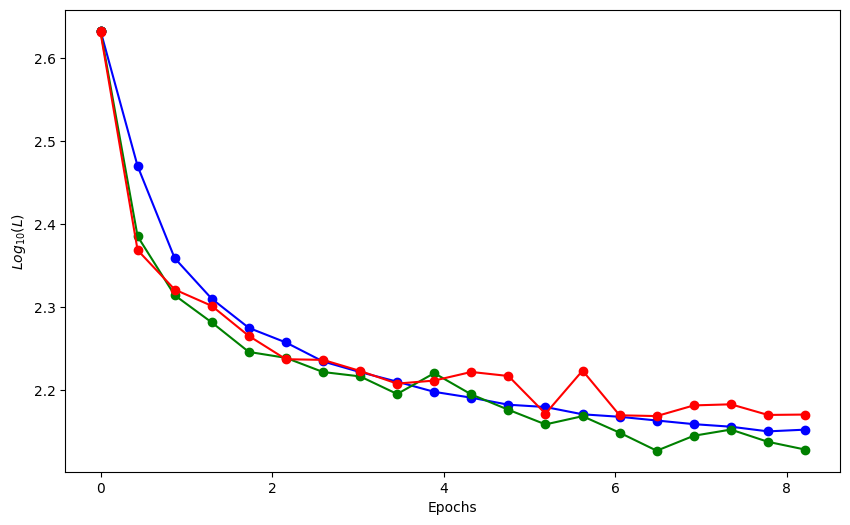

In [40]:
plot_training_history(history,
                      mini_batch_size,
                      seq_length,
                      len(training_data),
                      plot_smooth=True,
                      plot_val=True)

In [41]:
mykey = random.PRNGKey(1)

seq_length = 100

hidden_size = 256

mini_batch_size = 32

total_steps = 2000

history,out_params,out_hidden = train_character_lstm(                  
                                  seq_length=seq_length,
                                  hidden_size=hidden_size,
                                  mini_batch_size=mini_batch_size,
                                  learning_rate=0.01,
                                  total_steps=total_steps,
                                  steps_sample_freq=100,
                                  initial_key=mykey,
                                  training_data=training_data,
                                  validation_data=validation_data)  

tau: 231.388125 alpha: 0.9828615784645081
----
           ”kqmd'Ja0!1pU7p7ugNFQrgMyH4arrP5ZnIiM4X1bmuV7vo6'aW88”NW7k1U;mlU;4K3lVM3lgk7Er5.          
                  9YxbBKeoL9h;IfcgR9yYk0SjEr,H73PKVzL dEa,I4T“CUSZu?6hr8GoO9bEP aV                  
                      WVvcvjY“pj6R0YemwsYCyp,6hVCkOQ6eDI’'MRm1obvBgAkCvApb dF                        
----
Step n: 0	 Epoch: 0
Train Current: 429.0448	Train Smoothed: 429.0459
Val Current: 426.8568
----
           urraeve Eneis Nond. mo paenste cies fonttsest, Hus fuipy sat he peage shas, I fa          
            cost, eyd pre cood afa goftiet; And on brevesd wed the and congsolt feralans            
                             trettond, and ay thenl shitr be plall thea                              
----
Step n: 100	 Epoch: 0
Train Current: 229.6520	Train Smoothed: 282.8393
Val Current: 221.3626
----
              rorth refterse, In. aC the Ohres Pare: The feed con asd fel desids to the              
          gedreads, re lont and foo T

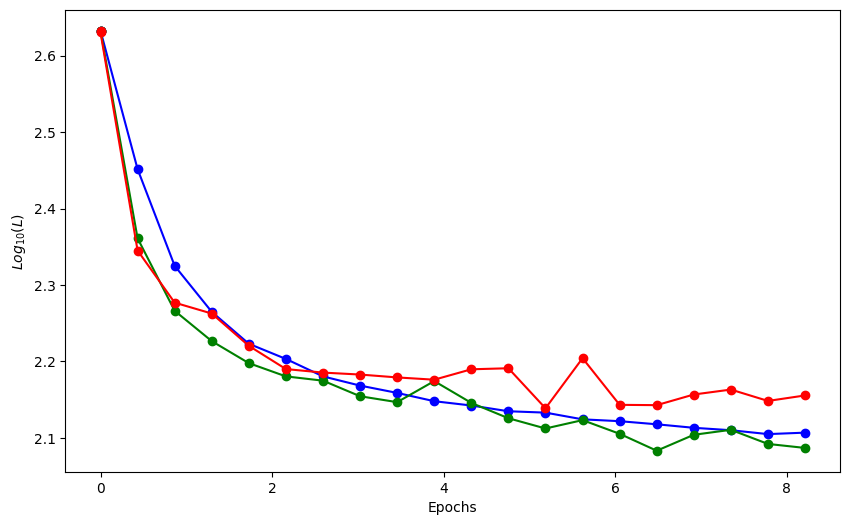

In [42]:
plot_training_history(history,
                      mini_batch_size,
                      seq_length,
                      len(training_data),
                      plot_smooth=True,
                      plot_val=True)

In [43]:

key = random.PRNGKey(7)

sample_size = 2000

key,subkey=random.split(key) #use key to get next key, subkey for random number

sample_ix = sample(12,sample_size,subkey,out_hidden,out_params[0])

In [44]:
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
txt_wrap = wrap(txt,80)
txt_wrap = [line.center(100) for line in txt_wrap]
txt = '\n'.join(txt_wrap)  # \n aren't in the character set so wrap text to make readable

print('----\n %s \n----' % (txt,))

----
            jent in war, What coursers fell not that has breathed in the prowess, Such old           
          encouch’d Him went controld, No wobliks of the charm’d around the battle stands,          
          Now all that held, is moved! ’eis that important ponders of the valiant lambs on          
           odiot dart, And spreads, and each was his most, O thick not ’vanceristhen for            
          some war’s soothous share his arms, with match’d in bleedled mind: By Teriphus,           
          and the sigep in solid might; With golden glad each altarsent, though restentle           
            of war on hast: And Pleas has wing’d in battle son beent; He insign’d their             
          heart; Behold, O Nestor and sons and Ajacem; in fail to renonged and death; The           
            foe.” Then thus the weight beast the heaven; Loud in the firlowing Greek and            
             hour, And’s weep the hy shuns, up those devouring through their conquest